# ${\textbf{Task 2 - Prediction of store sales}}$

**Prediction of sales is the central task in this challenge. We want to predict daily sales in                                 
various stores up to 6 weeks ahead of time. This will help the company plan ahead of time.**

In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')


# Handle table-like data and matrices
import numpy as np
import pandas as pd
import math 


# Modelling Algorithms
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import accuracy_score, mean_squared_error


# Modelling Helpers
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.model_selection import train_test_split
from IPython.display import display
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.preprocessing import LabelBinarizer, LabelEncoder


# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns


# Configure visualisations
%matplotlib inline
mpl.style.use( 'fivethirtyeight' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 18 , 8

pd.set_option('max_columns', None)
pd.set_option('max_rows', None)

## ${\textbf{Modularization of Codes}}$

In [2]:
 # the data will need alot of cleaning maybe not so much 
# let get started

# Function to calculate missing values by column
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Datatypes of missing values
        mis_val_dtypes = df.dtypes
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent, mis_val_dtypes], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values', 2 : 'Data Types'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns, mis_val_table_ren_columns.index


In [3]:
def fix_missing(df, column):
    """
    The Function Fix missing values in the data (df) passed
    df = dataframe that contains the missing columns
    column = columns that has missing values
    """
    for col in column:
        if df[col].dtype == 'float64' or df[col].dtype == 'int64':
            df[col] = df[col].fillna(df[col].median())
        else:
            df[col] = df[col].fillna('No Data')
    return df

In [4]:
def encode_categorical_to_integer(data, columns):
    from sklearn.preprocessing import LabelEncoder
    for col in columns:
        encoder = LabelEncoder()
        data[col] = encoder.fit_transform(data[col])

### ${\textbf{Read in Data}}$

In [121]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
store = pd.read_csv('data/store.csv')

train = pd.merge(train_df, store, how='inner', on='Store')
test = pd.merge(test_df, store, how='inner', on='Store')

In [122]:
# Drop all rows where Sales is 0
train = train[train['Sales'] > 0]
print(train.shape)

# remove all closed stores
train = train[train['Open'] != 0]

(844338, 18)


In [123]:
train.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [8]:
# Separate target from features
X = train.drop('Sales', axis=1)
y = np.log(train['Sales'])

## $Preprocessing Data$
1. Check and fix missing values
2. Extract features from date column
3. Convert object data type to integer
4. Scale data using Standard Scaler

 **are  there  missing  values?**


### ${\textbf{**Building Models with Sklearn Pipelines**}}$

In [102]:
# specify the numeric columns we dont want to transform
# numeric_columns=numerical_columns
class myTransformer():
    def __init__(self):
        print('Initializing Binarizer......\n')
        # initialize all binarizer variables
        print('Binarizer Ready for Use!!!!!\n')
        
        # initialize the data scaler
        self.dataScaler=Normalizer()
        print('Scaler is Ready!!')
        
    # Fit all the binarisers on the training data
    def fit(self,input_data):
         # Check Missing
        print('Fixing Missing Values if any\n for int/float column fill with median otherwise No Data')
        table, missing_column = missing_values_table(input_data)
        input_data = fix_missing(df=input_data, column=missing_column)

        print('Features Ready for Fitting\n')
        
        input_data["StateHoliday"] = input_data["StateHoliday"].map({0: 0, "0": 0, "a": 1, "b": 1, "c": 1})
        input_data['StateHoliday'] = input_data['StateHoliday'].astype(int)
        
        print('Features Encoded to Interger \n\nReady for Modelling\n')
        
    # Transform the input data using the fitted binarisers
    def transform(self,full_dataset,train=False):
        # making a copy of the input because we dont want to change the input in the main function
        input_data=full_dataset.copy()
        
        print('Extracting Features From Date object...\n')
        input_data['Date'] = pd.to_datetime(input_data['Date'])
        for attr in ['day', 'month', 'week', 'dayofweek', 'weekofyear']:
            input_data[attr] = getattr(input_data['Date'].dt, attr)
            input_data[attr] = getattr(input_data['Date'].dt, attr)
            
    ############################ New Features #################################
    
        input_data['year'] = input_data['Date'].dt.year
        input_data['is_weekend'] = (input_data['dayofweek'] >= 5)*1
        input_data['fortnight'] = input_data['day']%15
        input_data['which_fortnight'] = input_data['day']//15
        
        input_data['promo_per_competition_distance'] = input_data.groupby('Promo')['CompetitionDistance'].transform('mean')
        input_data['promo2_per_competition_distance'] = input_data.groupby('Promo2SinceWeek')['CompetitionDistance'].transform('mean')

        encode_categorical_to_integer(input_data, ['StoreType', 'Assortment']) 
        print('Data Transformed.... Up Next\n')
        
        
        # Drop Redundancy Columns
        print('Drop Unneccesary Columns..\n')
        columns_to_drop = [ 'Id', 'SalesPerCustomer', 'Customers', 'Date', 'PromoInterval',
                           'CompetitionOpenSinceYear','Promo2SinceYear', 'Store',
                           'dayofyear']
        for col in columns_to_drop:
            if col  in input_data.columns:
                input_data = input_data.drop(col, axis=1)
        # scale dataframe
        print('Scaling Data using Standard Scaler Method\n')
        table, missing_column = missing_values_table(input_data)
        input_data = fix_missing(df=input_data, column=missing_column)
        input_data = pd.DataFrame(self.dataScaler.fit_transform(input_data), columns=input_data.columns)
        print('Scaling Completed...')
        
        # this concatenates all the data
        print('Returning Data\n\n')
        print('Done!!!! Pipeline process completed')
        return input_data

### ${\textbf{Training and Evaluation Using the RMSLE Loss Funtion}}$

In [95]:
############################## Define a loss Funtion ########################################
import pickle
# Since it a sales prediction and it a continuous type of data using Root Mean Squared Error would be appropriete
def rmsle(true, pred):
    """Loss functions indicate how well our model is performing. This means that the loss 
        functions affect the overall output of sales prediction.  
        Different loss functions have different use cases. 
        true: actual prediction
        pred: model prediciton
        returns error value
        """
    from sklearn.metrics import mean_squared_error
    return np.sqrt(mean_squared_error(true, pred))

# Functions to train
def run_xgb(train_X, train_y, val_X, val_y, test_X, model_name=None):
    """Xtreme Gradient Boosting Regressor"""
    import xgboost as xgb
    params = {'objective': 'reg:squarederror',
             'eval_metric': 'rmse',
              'learning_rate': 0.1,
             'eta': 0.001,
             'max_depth': 9,
             'subsample': 0.6,
             'colsample_bytree':0.6,
             'alpha':0.001,
             'random_state':42,
             'silent':True}
    tr_data = xgb.DMatrix(train_X, train_y)
    va_data = xgb.DMatrix(val_X, val_y)
    watchlist = [(tr_data, 'train'), (va_data, 'valid')]
    print('XGB algorithm to train')
    model_xgb = xgb.train(params, tr_data, 500, watchlist, maximize=False, early_stopping_rounds=100,
                         verbose_eval=300)
    dtest = xgb.DMatrix(test_X)
    xgb_pred_y = model_xgb.predict(dtest, ntree_limit=model_xgb.best_ntree_limit)
    
     # save model
    pickle.dump(model_xgb, open(model_name, 'wb'))
    print(f'Model Saved {model_name}')
    
    return model_xgb, xgb_pred_y
def run_random_forest(train_X, train_y, val_X, val_y, test_X, model_name=None):
    """
    A random forest regressor.

    A random forest is a meta estimator that fits a number of classifying
    decision trees on various sub-samples of the dataset and uses averaging
    to improve the predictive accuracy and control over-fitting.
    The sub-sample size is always the same as the original
    input sample size but the samples are drawn with replacement if
    `bootstrap=True` (default).
    
    parameters....
    train_X = training features
    train_y = target values for training
    val_X = testing/validation dataset
    val_y = target values for evaluation/testing model perfrmance
    test_X = Test data to be predicted
    
    returns model = GB model and test prediction
    """
    from sklearn.ensemble import RandomForestRegressor
    model = RandomForestRegressor()
    print('Using Random Forest Regressor Algorithm to train')
    model.fit(train_X, train_y)
    predictions = model.predict(val_X)
    rmsle = rmse(val_y, predictions)
    print('RMSE = ', rmse.round(3))
     # save model
    pickle.dump(model, open(model_name, 'wb'))
    print(f'Model Saved {model_name}')
    
    print('\nPredicting Test data..')
    test_pred = model.predict(test_X)
    print('Prediction Completed')
    
    return model, test_pred

def run_gradient_boosting(train_X, train_y, val_X, val_y, test_X):
    """
    GB builds an additive model in a forward stage-wise fashion;
    it allows for the optimization of arbitrary differentiable loss functions.
    In each stage a regression tree is fit on the negative gradient of the
    given loss function.
    
    parameters....
    train_X = training features
    train_y = target values for training
    val_X = testing/validation dataset
    val_y = target values for evaluation/testing model perfrmance
    test_X = Test data to be predicted
    
    returns model = GB model and test prediction
    """
    from sklearn.ensemble import GradientBoostingRegressor
    model = GradientBoostingRegressor()
    print('Using GradientBoostingRegressor Algorithm', )
    model.fit(train_X, train_y)
    predictions = model.predict(val_X)
    rmsle = rmse(val_y, predictions)
    print('RMSE = ', rmse.round(3))
    
     # save model
    pickle.dump(model, open(model_name, 'wb'))
    print(f'Model Saved {model_name}')
    
    # predict test
    print('\nPredicting Test data..')
    test_pred = model.predict(test_X)
    print('Prediction Completed')
    return model, test_pred


In [103]:
# Separate target from features
train_features = train.drop('Sales', axis=1)
target = np.log(train['Sales'])
test = test

In [104]:
transformer=myTransformer()
transformer.fit(train_features)
transformed_train=transformer.transform(train_features,train=True)

Initializing Binarizer......

Binarizer Ready for Use!!!!!

Scaler is Ready!!
Fixing Missing Values if any
 for int/float column fill with median otherwise No Data
Your selected dataframe has 17 columns.
There are 6 columns that have missing values.
Features Ready for Fitting

Features Encoded to Interger 

Ready for Modelling

Extracting Features From Date object...

Data Transformed.... Up Next

Drop Unneccesary Columns..

Scaling Data using Standard Scaler Method

Your selected dataframe has 22 columns.
There are 0 columns that have missing values.
Scaling Completed...
Returning Data


Done!!!! Pipeline process completed


In [105]:
transformer.fit(test)
transformed_test=transformer.transform(test)
transformed_test.shape

Fixing Missing Values if any
 for int/float column fill with median otherwise No Data
Your selected dataframe has 17 columns.
There are 1 columns that have missing values.
Features Ready for Fitting

Features Encoded to Interger 

Ready for Modelling

Extracting Features From Date object...

Data Transformed.... Up Next

Drop Unneccesary Columns..

Scaling Data using Standard Scaler Method

Your selected dataframe has 22 columns.
There are 0 columns that have missing values.
Scaling Completed...
Returning Data


Done!!!! Pipeline process completed


(41088, 22)

### ${\textbf{Train with XGBoost Regressor}}$

In [108]:
model_name = '20-08-2020-16-32-31-00-xgboost.pkl'
from sklearn.model_selection import KFold
kfold, scores = KFold(n_splits=5, shuffle=True, random_state=221), list()
pred_tot_cb = []
for train, test in kfold.split(transformed_train):
    x_train, x_test = transformed_train.iloc[train], transformed_train.iloc[test]
    y_train, y_test = target.iloc[train], target.iloc[test]
    
    model = XGBRegressor(objective='reg:squarederror', random_state=27,  n_estimators=800, 
                         verbose=500,  learning_rate=0.21, early_stopping_rounds=200)
    model.fit(x_train, y_train)
    preds = model.predict(x_test)
    score = rmsle(y_test, preds)
    scores.append(score)
    test_pred = model.predict(transformed_test)
    pred_tot_cb.append(test_pred)
    print(score)
print("Average: ", sum(scores)/len(scores))

# save model
pickle.dump(model, open(model_name, 'wb'))
print(f'Model Saved {model_name}')


0.18922085250772927
0.1914596864920655
0.1916505729110095
0.19161111610567746
0.19154310333102223
Average:  0.1910970662695008
Model Saved 20-08-2020-16-32-31-00-xgboost.pkl


In [111]:

X_train, X_test, y_train, y_test = train_test_split(transformed_train, target, 
                                                    test_size=.2, random_state=12)
# model, test_pred = run_xgb(X_train, y_train, X_test, y_test, transformed_test, model_name)

In [17]:
model_name = '20-08-2020-16-32-31-00.pkl'

# model, test_pred = run_random_forest(X_train, y_train, X_test, y_test, transformed_test, model_name)

Using Random Forest Regressor Algorithm to train


KeyboardInterrupt: 

**Feature Importance**

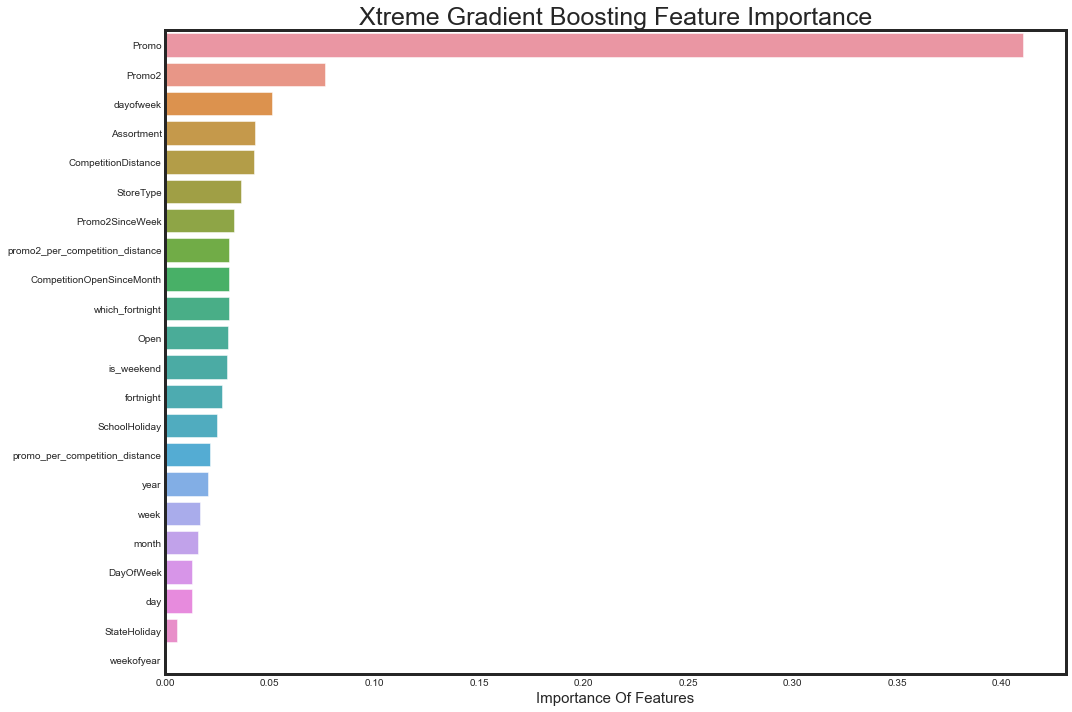

In [112]:

ranks = np.argsort(-model.feature_importances_)
f, ax = plt.subplots(figsize=(15, 10))

sns.barplot(x=model.feature_importances_[ranks], y=X_train.columns.values[ranks], orient='h')
ax.set_xlabel("Importance Of Features", fontsize=15)
ax.set_ylabel('Features Name', fontsize=15)
plt.title('Xtreme Gradient Boosting Feature Importance', size=25)
plt.tight_layout()
plt.show()

### ${\textbf{Post Prediction analysis }}$

Using Xtreme Gradient Boosting Prediction Determine the confidence interval of the predictions

Since all sales were log values, i used exponential to get there exact values back

Defining My Confidence Interval.

Most of the predictions are much higher than the actual values where the actual value is less than 10000. Any actual value that is higher than 10,000 our model predict less approx. 3,000.

Confidence Interval is a bound on an estimate of a population parameter

In [129]:
from statsmodels.stats.proportion import proportion_confint
lower, upper = proportion_confint(5000, train.shape[0], 0.05)

print('lower=%.3f, upper=%.3f' %(lower, upper))

lower=0.006, upper=0.006


**Serialize a Model**

In [109]:
load_model = pickle.load(open('20-08-2020-16-32-31-00-xgboost.pkl', 'rb'))
print('model loaded')

model loaded


In [113]:
rmse = rmsle(y_test, load_model.predict(X_test))
rmse

0.18992964618941963

**A Predict Function**

In [115]:
test_pred = load_model.predict(transformed_test)
np.exp(test_pred[3:7])

array([7798.1313, 4480.602 , 5349.0684, 4927.0786], dtype=float32)

In [116]:
cols = test.columns.values
cols

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [117]:
def predict_sale(data, model):
    if type(data) == dict:
        df = pd.DataFrame(data)
    else:
        df = data
    pipeline = myTransformer()
    pipeline.fit(df)
    prepared_df = pipeline.transform(df)
    prediction = model.predict(prepared_df)
    prediction = np.exp(prediction)
    return prediction

In [126]:
test.iloc[:5]

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,1,4,2015-09-17,1.0,1,0,0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,857,1,3,2015-09-16,1.0,1,0,0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
2,1713,1,2,2015-09-15,1.0,1,0,0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,2569,1,1,2015-09-14,1.0,1,0,0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
4,3425,1,7,2015-09-13,0.0,0,0,0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN


In [128]:
# test the function
data_test = test.fillna(0)
pred = predict_sale(data_test, load_model)

# print(f"Predictions = {pred}")

Initializing Binarizer......

Binarizer Ready for Use!!!!!

Scaler is Ready!!
Fixing Missing Values if any
 for int/float column fill with median otherwise No Data
Your selected dataframe has 17 columns.
There are 0 columns that have missing values.
Features Ready for Fitting

Features Encoded to Interger 

Ready for Modelling

Extracting Features From Date object...

Data Transformed.... Up Next

Drop Unneccesary Columns..

Scaling Data using Standard Scaler Method

Your selected dataframe has 22 columns.
There are 0 columns that have missing values.
Scaling Completed...
Returning Data


Done!!!! Pipeline process completed
Predictions = [10283.7705 15850.505  24640.162  20032.426   4312.735 ]


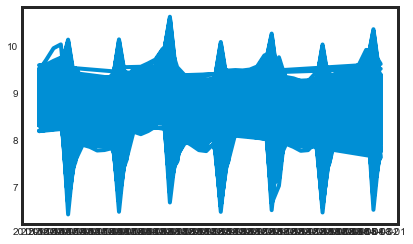

In [131]:
plt.plot(test['Date'], test_pred)

**Heat-Map to show correlation b/w numerical attributes**

<AxesSubplot:>

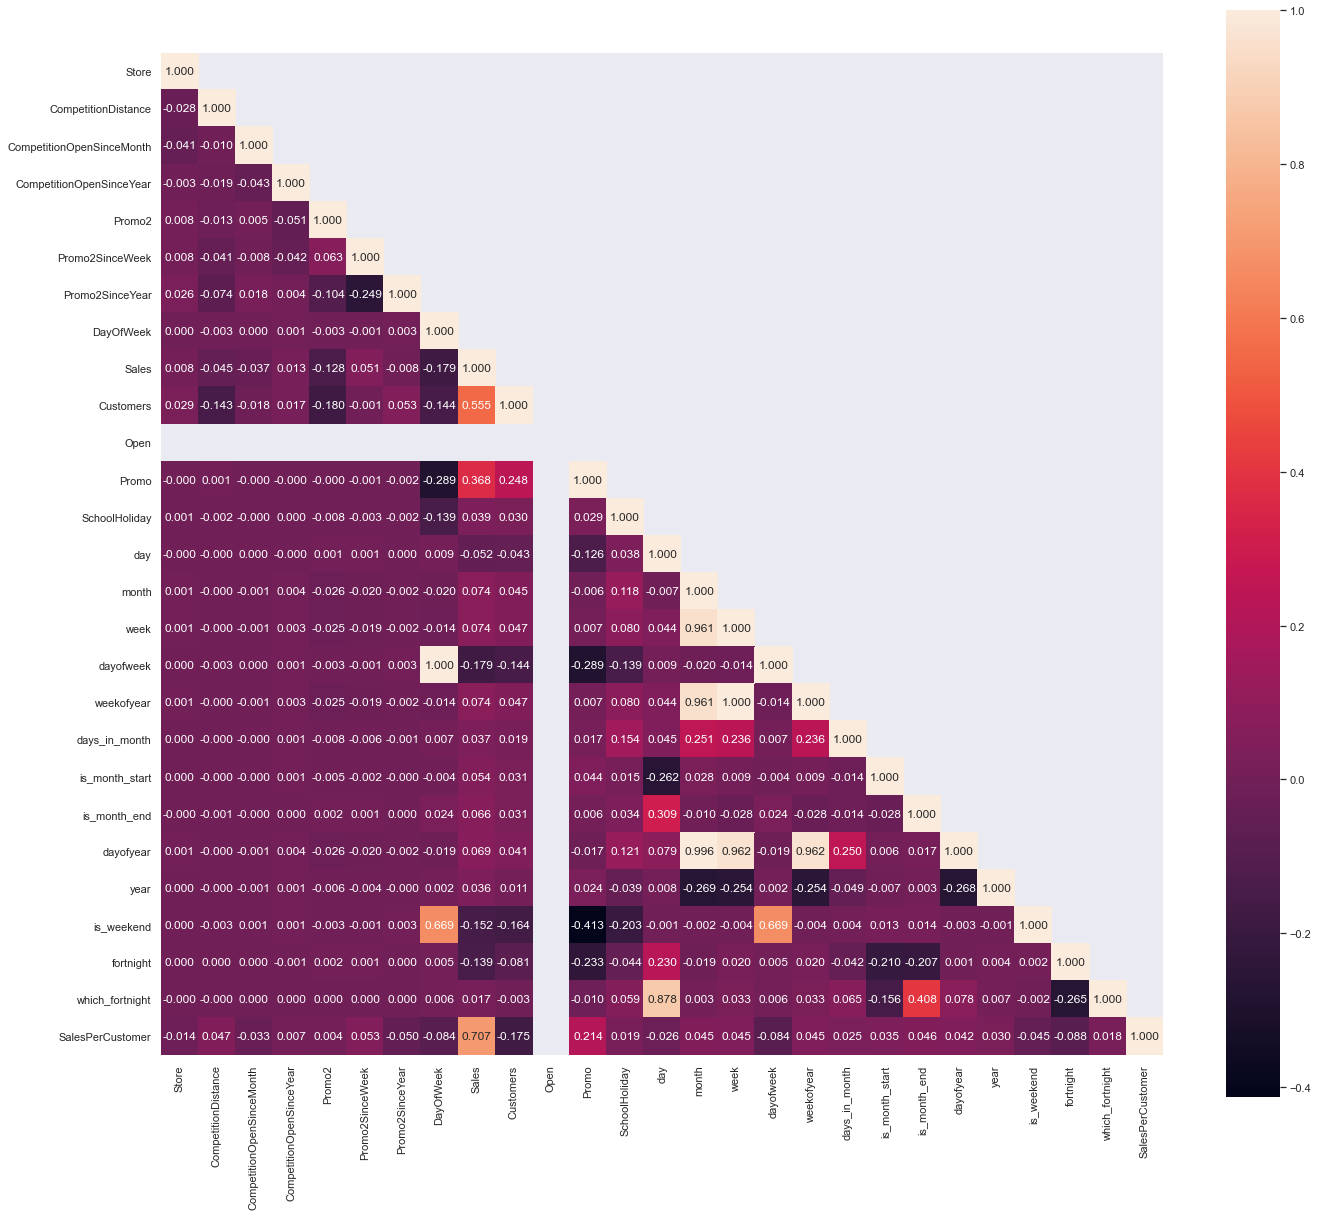

In [107]:
sns.set(font_scale=1.0)
correlation_map = train_data[train_data.columns].corr()
obj = np.array(correlation_map)
obj[np.tril_indices_from(obj)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,20)
sns.heatmap(correlation_map, fmt='.3f', mask=obj,vmax=1.0, square=True, annot=True)

In [ ]:
# l_pipeline = Pipeline(steps = [
#     ("features", FeatureUnion([
#         (
#             "numerical_features",
#             ColumnTransformer([
#                 (
#                     "numerical",
#                     Pipeline(steps=[(
#                         "impute_stage",
#                         SimpleImputer(missing_values=np.nan, strategy='median')
#                     )]),
#                     ["feature_1"]
#                 )
#             ])
#         ), (
#             "categorical_features",
#             ColumnTransformer([
#                 (
#                     "encoding",
#                     Pipeline(steps=[
#                         ('ohe', OneHotEncoder(handle_unknown='ignore')),
#                         ('reduction', NMF(n_components=16)),
#                     ]),
#                     ['StoreType']
#                 ),
#             ])
#         )
#     ]))
#     ('regressor', GradientBoostingRegressor())
# ])
# l_pipeline.fit(features, target)
# pred = l_pi.predict(test_data)

In [ ]:
# from sklearn.pipeline import make_pipeline, Pipeline
# from sklearn.preprocessing import PCA

# model_pipeline = Pipeline(steps = [
#     ('dimension_reduction', PCA(n_components=15)),
#     ('linear_model', LinearRegression())
# ])

# model_pipeline.fit(sc_train_features.values, target)
# predictions = model_pipeline.predict(sc_test_features)